# Qwen2-VL

In [1]:
# Inference section must be on 3.10.14 # green_score must be on different, as only works on specific python versio 
import sys
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [2]:
# Python 3.10.14
# Below works only on Python > 3.9 
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall
# pip show torch # 2.5.1+cu121
# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# pip install pandas matplotlib pillow tqdm 
# pip install gdown

In [3]:
if False: 
    !gdown https://drive.google.com/uc?id=1nlc9-jm9eFIwLyMHdPqmxauB-fHyrkTn

    import shutil
    shutil.unpack_archive('data.zip') 

In [4]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from unsloth import FastVisionModel
import torch

from collections import Counter
pd.options.display.max_rows = 5

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used

In [5]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3]

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [6]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

,report,split
id,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train
...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test


In [7]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot)

len(ids_annot), ids_annot[:3]

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [8]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image

    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

,report,split,image
id,,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train,<PIL.Image.Image image mode=RGB size=512x1074 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


In [9]:
# df_data.to_pickle('data/df_data.pkl') # should hande images
df_data.drop(columns='image').to_pickle('data/df_data.pkl')

In [10]:
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test

,report,split,image
id,,,
CXR3030_IM-1405,"{'bone': 'No acute bony abnormality.', 'heart'...",test,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR38_IM-1911,"{'bone': 'Bony structures are intact.', 'heart...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


# Inference on Test Data 

In [47]:
from transformers import TextStreamer

model_name = "Aidan777/Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report"

model, tokenizer = FastVisionModel.from_pretrained(
                                        model_name=model_name, 
                                        load_in_4bit=True)

==((====))==  Unsloth 2025.1.7: Fast Qwen2_Vl vision patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [48]:
instruction_user = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided.
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.
"""

In [ ]:
FastVisionModel.for_inference(model)

outputs = {}
for i in tqdm(range(len(data_test))):

    image = data_test.iloc[i]['image']
    idx   = data_test.index[i]
    assert isinstance(image, Image.Image)  
    
    messages = [{"role": "user",
                 "content": [{"type": "image"},
                             {"type": "text", "text": instruction_user}]}]

    input_text    = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs        = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    output = model.generate(**inputs,
                            streamer=text_streamer,
                            max_new_tokens=128, # of the output
                            use_cache=True,
                            temperature=1.5,
                            min_p=0.1)

    decoded_text  = tokenizer.decode(output[0], skip_special_tokens=True)
    required_text = decoded_text.split('assistant\n', 1)[-1]
    del output
    
    outputs[idx] = required_text

  0%|          | 0/590 [00:00<?, ?it/s]

bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.<|im_end|>
bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.<|im_end|>
bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.<|im_end|>
bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.<|im_end|>
bone: No acute bony abnormalities. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contours are normal.<|im_end|>
bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effu

In [15]:
file_name = "Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report_TEST_OUTPUT.json"

with open(file_name, "w") as file:
    json.dump(outputs, file, indent=4) 

- For inference this models takes -
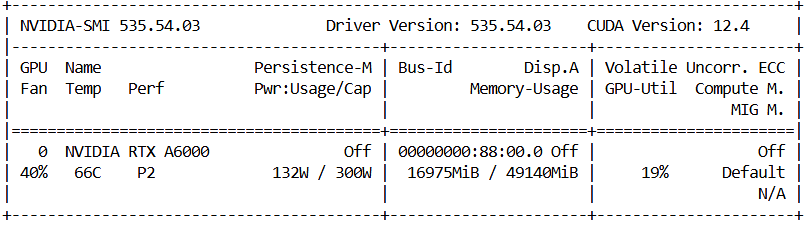

# Model Performance Evaluation

## Calculate green_score on true vs. inferred data